###  STEPS:
     1. we will collect the data 
     2. Preproces the data- Train and Test
     3. Create an stacked LSTM model 
     4. Predict the test data and plot the output
     5. predict the future prediction

In [1]:
import pandas_datareader as pdr
import numpy as np

In [2]:
df = pdr.get_data_tiingo('AAPL',api_key='9ab123036407606f2ed5adc171865f6988485eca')

In [3]:
df.to_csv('APPL.csv',)

In [4]:
df.head()

close     high     low    open    volume  \
symbol date                                                                   
AAPL   2015-10-19 00:00:00+00:00  111.73  111.750  110.11  110.80  29759153   
       2015-10-20 00:00:00+00:00  113.77  114.170  110.82  111.34  48967763   
       2015-10-21 00:00:00+00:00  113.76  115.580  113.70  114.00  42326974   
       2015-10-22 00:00:00+00:00  115.50  115.500  114.10  114.33  41654089   
       2015-10-23 00:00:00+00:00  119.08  119.228  116.33  116.70  59366914   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
AAPL   2015-10-19 00:00:00+00:00  25.809095  25.813715  25.434883  25.594270   
       2015-10-20 00:00:00+00:00  26.280326  26.372724  25.598890  25.719007   
       2015-10-21 00:00:00+00:00  26.278016  26.698427  26.264156  26.333455   
       2015-10-22 00:00:00+00:00  26.679947  26.679947  26.356554  26.409683   
       2015-10-23 00:00:00+00:00  27.506910  27.541098  26.871673  26.957142   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2015-10-19 00:00:00+00:00  119036612      0.0          1.0  
       2015-10-20 00:00:00+00:00  195871052      0.0          1.0  
       2015-10-21 00:00:00+00:00  169307896      0.0          1.0  
       2015-10-22 00:00:00+00:00  166616356      0.0          1.0  
       2015-10-23 00:00:00+00:00  237467656      0.0          1.0

In [5]:
df1 = df.reset_index()['close']

In [6]:
df1

0       111.73
1       113.77
2       113.76
3       115.50
4       119.08
         ...  
1253    116.97
1254    124.40
1255    121.10
1256    121.19
1257    120.71
Name: close, Length: 1258, dtype: float64

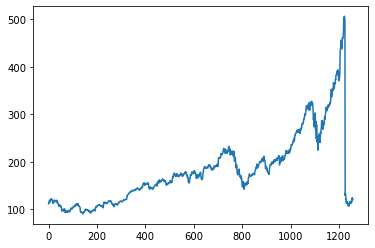

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1

array([[0.05144919],
       [0.05635598],
       [0.05633193],
       ...,
       [0.07398677],
       [0.07420325],
       [0.07304871]])

In [11]:
df1.shape

(1258, 1)

In [12]:
## spliting dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(817, 441)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)    

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [17]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 382ms/step - loss: 0.0074 - val_loss: 0.0560
Epoch 2/100
12/12 [==============================] - 2s 179ms/step - loss: 0.0015 - val_loss: 0.0231
Epoch 3/100
12/12 [==============================] - 3s 213ms/step - loss: 5.9040e-04 - val_loss: 0.0211
Epoch 4/100
12/12 [==============================] - 3s 220ms/step - loss: 4.1257e-04 - val_loss: 0.0200
Epoch 5/100
12/12 [==============================] - 2s 190ms/step - loss: 3.9966e-04 - val_loss: 0.0195
Epoch 6/100
12/12 [==============================] - 2s 201ms/step - loss: 3.3890e-04 - val_loss: 0.0193
Epoch 7/100
12/12 [==============================] - 3s 251ms/step - loss: 3.2738e-04 - val_loss: 0.0192
Epoch 8/100
12/12 [==============================] - 3s 223ms/step - loss: 3.4081e-04 - val_loss: 0.0185
Epoch 9/100
12/12 [==============================] - 2s 203ms/step - loss: 3.1352e-04 - val_loss: 0.0172
Epoch 10/100
12/12 [==============================] - 2s 199ms/

12/12 [==============================] - 2s 193ms/step - loss: 1.1523e-04 - val_loss: 0.0101
Epoch 79/100
12/12 [==============================] - 2s 193ms/step - loss: 1.0688e-04 - val_loss: 0.0095
Epoch 80/100
12/12 [==============================] - 2s 194ms/step - loss: 1.0523e-04 - val_loss: 0.0094
Epoch 81/100
12/12 [==============================] - 2s 191ms/step - loss: 1.0580e-04 - val_loss: 0.0101
Epoch 82/100
12/12 [==============================] - 2s 192ms/step - loss: 1.0170e-04 - val_loss: 0.0084
Epoch 83/100
12/12 [==============================] - 2s 190ms/step - loss: 9.7230e-05 - val_loss: 0.0082
Epoch 84/100
12/12 [==============================] - 2s 189ms/step - loss: 1.0631e-04 - val_loss: 0.0091
Epoch 85/100
12/12 [==============================] - 2s 194ms/step - loss: 1.1447e-04 - val_loss: 0.0084
Epoch 86/100
12/12 [==============================] - 2s 197ms/step - loss: 9.7391e-05 - val_loss: 0.0076
Epoch 87/100
12/12 [==============================] - 2s 20

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [37]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [38]:

import matplotlib.pyplot as plt

In [39]:
len(df1)

1258

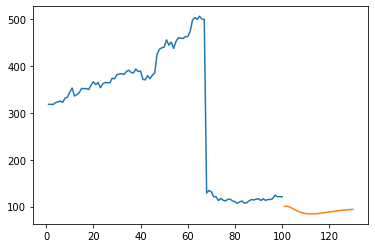

In [40]:

plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

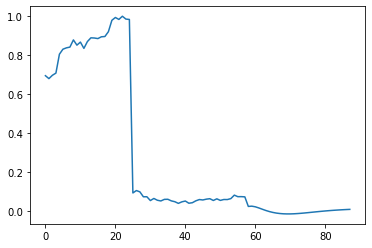

In [41]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [42]:
df3=scaler.inverse_transform(df3).tolist()

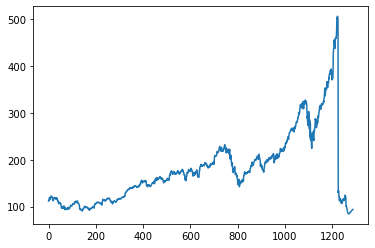

In [43]:

plt.plot(df3)